In [1]:
import pdb
import numpy as np
import os
from astropy.wcs import WCS
from shift import shift_twod
from VieroLibrary.dist_idl import dist_idl
from VieroLibrary import readcol
import loggen
from lmfit import Parameters, minimize, fit_report
from astropy.io import fits
from gauss_kern import gauss_kern
#import pylab as pl
import matplotlib.pyplot as plt
import math
import pylab
from grab_random import grab_random
import pylab as plt
#from viero_quick_stack import viero_quick_stack
#from viero_quick_stack import viero_class_stack
from sedstack import stack_objects_in_redshift_slices
#from sedstack import stack_objects_in_padded_redshift_slices

%matplotlib inline  

In [2]:
z_lo = np.array([0.0,0.5,1.0,1.5,2.0,2.5,3.0,3.5])
z_hi = np.array([0.5,1.0,1.5,2.0,2.5,3.0,3.5,4.0])

m_lo = np.array([8.5, 9.5,10.0,10.5,11.0])
m_hi = np.array([9.5,10.0,10.5,11.0,13.0])

In [3]:
wv0 = np.array([1,1,1,1,1,1])
#wv0 = np.array([0,0,1,1,1,0])
indstack = np.where(wv0 == 1)
mapname=['_green'
         ,'_red'
         ,'_PSW'
         ,'_PMW'
         ,'_PLW'
         ,'_aztec'
        ]
library_keys =['pacs_green'
               ,'pacs_red'
               ,'spire_PSW'
               ,'spire_PMW'
               ,'spire_PLW'
               ,'aztec'
              ]
wavelength=[100,160,250,350,500,1100]
nwv = np.sum(wv0)#len(mapname)
fwhm =[7.4, 11.3,18.1, 25.2, 36.6,18.]
efwhm=[6.7, 11.2,17.6, 23.9, 35.2,18.] # want to the measured effective FWHM later
color_correction=[23.58,23.82,1.018,0.9914,0.95615,1.0]

dir_spire_maps = '/data/maps_cats_models/maps/herschel/hermes/cosmos/'
dir_pacs_maps = '/data/maps_cats_models/maps/herschel/pacs/pep_cosmos_DR1/maps/'
dir_aztec_maps = '/data/maps_cats_models/maps/aztec/cosmos/forPeter/'
maps = [dir_spire_maps+'cosmos-cropped-uvista_5.0_arcsec_pixels_green_flux.fits' 
        #dir_pacs_maps+'pep_COSMOS_green_Map.DR1.fits'
        ,dir_spire_maps+'cosmos-cropped-uvista_5.0_arcsec_pixels_red_flux.fits' 
        #,dir_pacs_maps+'pep_COSMOS_red_Map.DR1.fits'
        ,dir_spire_maps+'cosmos-cropped-uvista-hipe12_itermap_10_iterations_5.0_arcsec_pixels_PSW_flux.fits'
        ,dir_spire_maps+'cosmos-cropped-uvista-hipe12_itermap_10_iterations_5.0_arcsec_pixels_PMW_flux.fits'
        ,dir_spire_maps+'cosmos-cropped-uvista-hipe12_itermap_10_iterations_5.0_arcsec_pixels_PLW_flux.fits'
        #,dir_aztec_maps+'cosmos_jcmt_kscott20100925_map.fits'
        ,dir_spire_maps+'cosmos-cropped-uvista_5.0_arcsec_pixels_aztec_flux.fits'
       ]
noises = [dir_spire_maps+'cosmos-cropped-uvista_5.0_arcsec_pixels_green_noise.fits' 
          #dir_pacs_maps+'pep_COSMOS_green_Map.DR1.err.fits'
          ,dir_spire_maps+'cosmos-cropped-uvista_5.0_arcsec_pixels_red_noise.fits' 
          #,dir_pacs_maps+'pep_COSMOS_red_Map.DR1.err.fits' 
          ,dir_spire_maps+'cosmos-cropped-uvista-hipe12_itermap_10_iterations_5.0_arcsec_pixels_PSW_noise.fits'
          ,dir_spire_maps+'cosmos-cropped-uvista-hipe12_itermap_10_iterations_5.0_arcsec_pixels_PMW_noise.fits'
          ,dir_spire_maps+'cosmos-cropped-uvista-hipe12_itermap_10_iterations_5.0_arcsec_pixels_PLW_noise.fits'
          #,dir_aztec_maps+'cosmos_jcmt_kscott20100925_weight.fits'
          ,dir_spire_maps+'cosmos-cropped-uvista_5.0_arcsec_pixels_aztec_noise.fits'
         ]#weight??
beams = ['/data/maps_cats_models/maps/herschel/pacs/pep_cosmos_DR1/PSF_observed_used/pep_COSMOS_green_Psf.DR1.fits'
         ,'/data/maps_cats_models/maps/herschel/pacs/pep_cosmos_DR1/PSF_observed_used/pep_COSMOS_red_Psf.DR1.fits'
         ,'/data/maps_cats_models/maps/beams/SPIRE/model/psw-model-beam_5_arcsec_pixels.fits'
         ,'/data/maps_cats_models/maps/beams/SPIRE/model/pmw-model-beam_5_arcsec_pixels.fits'
         ,'/data/maps_cats_models/maps/beams/SPIRE/model/plw-model-beam_5_arcsec_pixels.fits'
         ,'/data/maps_cats_models/maps/beams/aztec/aztec-beam_5_arcsec_pixels.fits'
        ]
sedstackbeams = [beams[0],beams[1],beams[2],beams[3],beams[4],beams[5]]

In [4]:
print beams[4]
beam, phd = fits.getdata(beams[4], 0, header = True)
print np.shape(beam)
if 'CD2_2' in phd:
    pix_beam = phd['CD2_2'] * 3600.
elif 'CDELT2' in phd:
    pix_beam = phd['CDELT2'] * 3600.
print pix_beam

/data/maps_cats_models/maps/beams/SPIRE/model/plw-model-beam_5_arcsec_pixels.fits
(72, 72)
4.9999998672


In [5]:
from skymaps import Skymaps
sky_library_gaussians={}
sky_library_psfs={}

#for t in range(len(mapname)):
for t in indstack[0]:
    #sky_library[library_keys[t]] = Skymaps(maps[t],noises[t],beams[t],color_correction=color_correction[t])
    sky_library_gaussians[library_keys[t]] = Skymaps(maps[t],noises[t],efwhm[t],color_correction=color_correction[t])
    sky_library_psfs[library_keys[t]] = Skymaps(maps[t],noises[t],sedstackbeams[t],color_correction=color_correction[t])
    sky_library_gaussians[library_keys[t]].add_wavelength(wavelength[t])
    sky_library_gaussians[library_keys[t]].add_fwhm(efwhm[t])    
    sky_library_psfs[library_keys[t]].add_wavelength(wavelength[t])
    sky_library_psfs[library_keys[t]].add_fwhm(efwhm[t])
    #if library_keys[t] == 'aztec': 
    #    sky_library_psfs[library_keys[t]].add_weights(noises[t])
    #pdb.set_trace()
#b = '/data/maps_cats_models/maps/beams/SPIRE/neptune_5.0_arcsec_pixels_PSW.fits'
#spire_PSW = Skymaps(path_map+fmf[2]+ mapname[2] + '_flux.fits',path_map+fmf[2]+ mapname[2] +'_noise.fits',b,color_correction=color_correction[2])

In [6]:
#z_lo = np.array([1.0,2.5])
#z_hi = np.array([1.5,3.0])
#z_lo = np.array([1.5])
#z_hi = np.array([2.0])
z_mid = (z_lo+z_hi)/2.0
nz = len(z_mid)

m_mid = (m_lo+m_hi)/2.0
nm = len(m_mid)

In [7]:
pop_suf = ['_sf','_qt','_agn','_sb','_loc']
popcolor=['blue','red','green','orange','black']

linear_mass = 1
if linear_mass == 1:
    linear_mass_suf = '_linear-'
else:
    linear_mass_suf = '_'

In [8]:
path_5_pop = '/data/maps_cats_models/catalogs/multi_pop_lists/5pops/'
npop=5
ngal = np.zeros([nz,nm,npop])
for iz in range(nz):
    z_suf = ""+"-".join([str(z_lo[iz]),str(z_hi[iz])])
    for jm in range(nm):
        m_suf = ""+"-".join([str(m_lo[jm]),str(m_hi[jm])])
        for kpop in range(npop):
            file_list ='list_5pop_z-'+z_suf+linear_mass_suf+'m-'+m_suf+pop_suf[kpop]+'.csv'
            ngal[iz,jm,kpop]=os.path.getsize(path_5_pop+file_list)
#print ngal

spire_PSW
aztec
pacs_red
spire_PMW
spire_PLW
pacs_green
250 cube smoothed
1100 cube smoothed
160 cube smoothed
350 cube smoothed
500 cube smoothed
100 cube smoothed


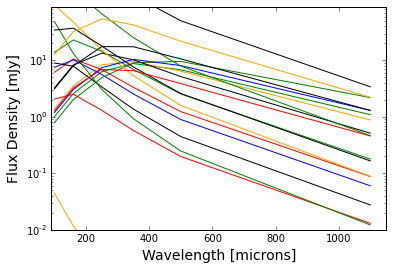

spire_PSW
aztec
pacs_red
spire_PMW
spire_PLW
pacs_green
250 cube smoothed
1100 cube smoothed
160 cube smoothed
350 cube smoothed
500 cube smoothed
100 cube smoothed


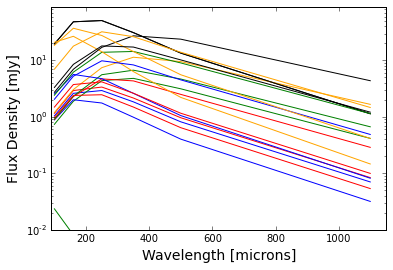

spire_PSW
aztec
pacs_red
spire_PMW
spire_PLW
pacs_green
250 cube smoothed
1100 cube smoothed
160 cube smoothed
350 cube smoothed
500 cube smoothed
100 cube smoothed


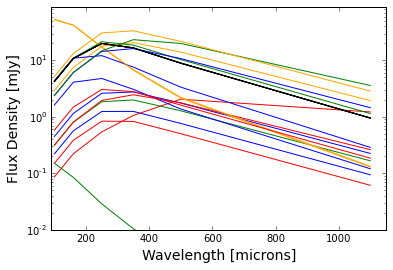

spire_PSW
aztec
pacs_red
spire_PMW
spire_PLW
pacs_green
250 cube smoothed
1100 cube smoothed
160 cube smoothed
350 cube smoothed
500 cube smoothed
100 cube smoothed


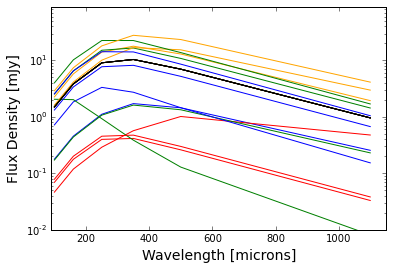

spire_PSW
aztec
pacs_red
spire_PMW
spire_PLW
pacs_green
250 cube smoothed
1100 cube smoothed
160 cube smoothed
350 cube smoothed
500 cube smoothed
100 cube smoothed


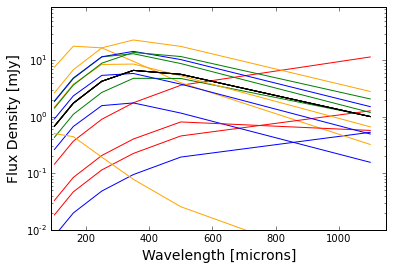

spire_PSW
aztec
pacs_red
spire_PMW
spire_PLW
pacs_green
250 cube smoothed
1100 cube smoothed
160 cube smoothed
350 cube smoothed
500 cube smoothed
100 cube smoothed


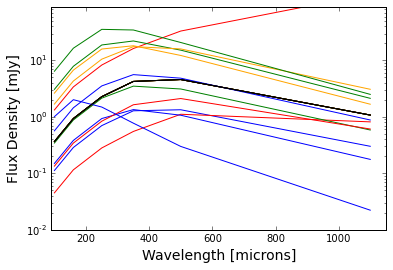

spire_PSW
aztec
pacs_red
spire_PMW
spire_PLW
pacs_green
250 cube smoothed
1100 cube smoothed
160 cube smoothed
350 cube smoothed
500 cube smoothed
100 cube smoothed


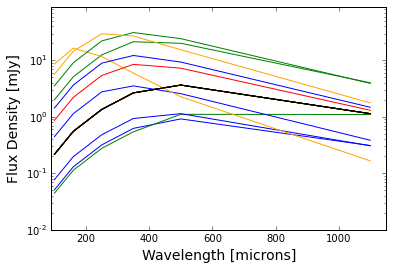

spire_PSW
aztec
pacs_red
spire_PMW
spire_PLW
pacs_green
250 cube smoothed
1100 cube smoothed
160 cube smoothed
350 cube smoothed
500 cube smoothed
100 cube smoothed


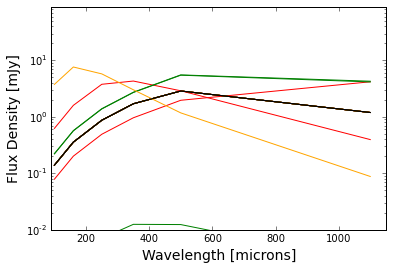

In [9]:
npop=5
all_stacked_fluxes_psfs = np.zeros([nwv,nz,nm,npop])
all_luminosity_temp_psfs= np.zeros([nz,nm,npop,2])

path_5_pop = '/data/maps_cats_models/catalogs/multi_pop_lists/5pops/'
for iz in range(nz):
    #Stack one z at a time

    list_names=[]
    z_suf = ""+"-".join([str(z_lo[iz]),str(z_hi[iz])])
    for jm in range(nm):
        m_suf = ""+"-".join([str(m_lo[jm]),str(m_hi[jm])])
        for kpop in range(npop):
            file_list ='list_5pop_z-'+z_suf+linear_mass_suf+'m-'+m_suf+pop_suf[kpop]+'.csv'
            list_names.append(path_5_pop+file_list)
    
    stacked_fluxes_psfs =  None
    n_sources_max = None
    [stacked_fluxes_psfs,v] = stack_objects_in_redshift_slices(
        sky_library_psfs,
        list_names,
        zed = z_mid[iz])
    
    #PLOT
    plt.ylim([-1e-1,3e0])
    plt.ylim([1e-2,9e1])
    plt.xlim([90,510])
    plt.xlim([90,1150])
    plt.yscale('log')
    plt.ylabel('Flux Density [mJy]',fontsize=14)
    plt.xlabel('Wavelength [microns]',fontsize=14)
    for j in range(nm): 
        for k in range(npop):
            all_stacked_fluxes_psfs[:,iz,j,k]= stacked_fluxes_psfs[:,npop*j+k]
            all_luminosity_temp_psfs[iz,j,k,:] = np.asarray([v['L'+str(npop*j+k)],v['T'+str(npop*j+k)]])
            plt.plot(np.array(wavelength)[indstack],1e3*stacked_fluxes_psfs[:,npop*j+k],color=popcolor[k])
        
    plt.show()
    #pdb.set_trace()

spire_PSW
aztec
pacs_red
spire_PMW
spire_PLW
pacs_green
250 cube smoothed
1100 cube smoothed
160 cube smoothed
350 cube smoothed
500 cube smoothed
100 cube smoothed


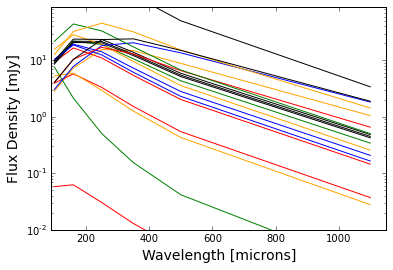

spire_PSW
aztec
pacs_red
spire_PMW
spire_PLW
pacs_green
250 cube smoothed
1100 cube smoothed
160 cube smoothed
350 cube smoothed
500 cube smoothed
100 cube smoothed


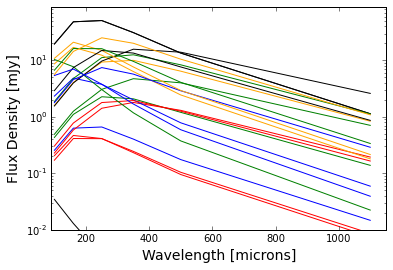

spire_PSW
aztec
pacs_red
spire_PMW
spire_PLW
pacs_green
250 cube smoothed
1100 cube smoothed
160 cube smoothed
350 cube smoothed
500 cube smoothed
100 cube smoothed


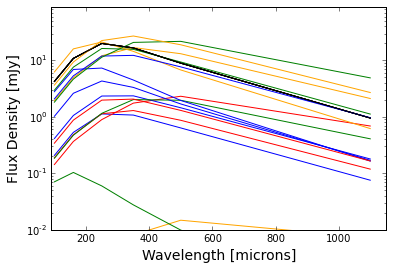

spire_PSW
aztec
pacs_red
spire_PMW
spire_PLW
pacs_green
250 cube smoothed
1100 cube smoothed
160 cube smoothed
350 cube smoothed
500 cube smoothed
100 cube smoothed


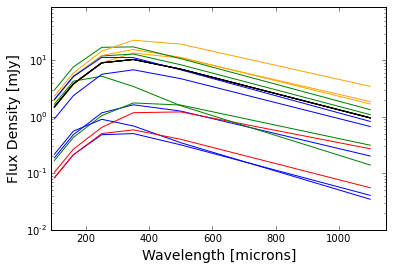

spire_PSW
aztec
pacs_red
spire_PMW
spire_PLW
pacs_green
250 cube smoothed
1100 cube smoothed
160 cube smoothed
350 cube smoothed
500 cube smoothed
100 cube smoothed


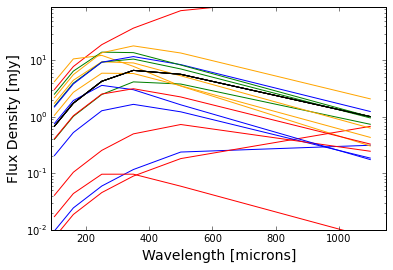

spire_PSW
aztec
pacs_red
spire_PMW
spire_PLW
pacs_green
250 cube smoothed
1100 cube smoothed
160 cube smoothed
350 cube smoothed
500 cube smoothed
100 cube smoothed


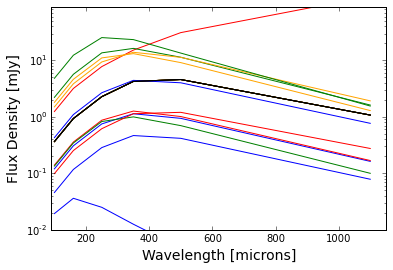

spire_PSW
aztec
pacs_red
spire_PMW
spire_PLW
pacs_green
250 cube smoothed
1100 cube smoothed
160 cube smoothed
350 cube smoothed
500 cube smoothed
100 cube smoothed


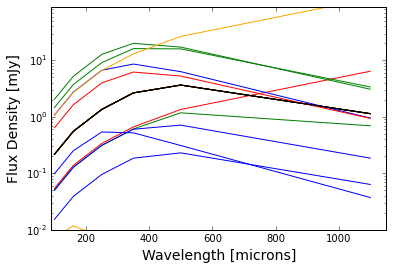

spire_PSW
aztec
pacs_red
spire_PMW
spire_PLW
pacs_green
250 cube smoothed
1100 cube smoothed
160 cube smoothed
350 cube smoothed
500 cube smoothed
100 cube smoothed


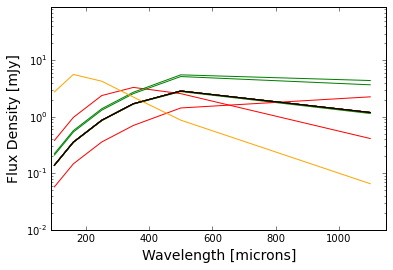

In [10]:
npop=5
all_stacked_fluxes_gaussians = np.zeros([nwv,nz,nm,npop])
all_luminosity_temp_gaussians = np.zeros([nz,nm,npop,2])

path_5_pop = '/data/maps_cats_models/catalogs/multi_pop_lists/5pops/'
for iz in range(nz):
    #Stack one z at a time

    list_names=[]
    z_suf = ""+"-".join([str(z_lo[iz]),str(z_hi[iz])])
    for jm in range(nm):
        m_suf = ""+"-".join([str(m_lo[jm]),str(m_hi[jm])])
        for kpop in range(npop):
            file_list ='list_5pop_z-'+z_suf+linear_mass_suf+'m-'+m_suf+pop_suf[kpop]+'.csv'
            list_names.append(path_5_pop+file_list)
    
    stacked_fluxes_gaussians =  None
    n_sources_max = None
    [stacked_fluxes_gaussians,v] = stack_objects_in_redshift_slices(
        sky_library_gaussians,
        list_names,
        zed = z_mid[iz])
    
    #PLOT
    plt.ylim([-1e-1,3e0])
    plt.ylim([1e-2,9e1])
    plt.xlim([90,510])
    plt.xlim([90,1150])
    plt.yscale('log')
    plt.ylabel('Flux Density [mJy]',fontsize=14)
    plt.xlabel('Wavelength [microns]',fontsize=14)
    for j in range(nm): 
        for k in range(npop):
            all_stacked_fluxes_gaussians[:,iz,j,k]= stacked_fluxes_gaussians[:,npop*j+k]
            all_luminosity_temp_gaussians[iz,j,k,:] = np.asarray([v['L'+str(npop*j+k)],v['T'+str(npop*j+k)]])
            plt.plot(np.array(wavelength)[indstack],1e3*stacked_fluxes_gaussians[:,npop*j+k],color=popcolor[k])
        
    plt.show()
    #pdb.set_trace()

In [11]:
date = '02212016'
path_save = '/data/sedstack/flux_temperature_luminosity_files/'
file_save1 = 'fluxes_'+str(npop)+'_pops_'+date+'_psfs.npy'
file_save2 = 'luminosities_temperatures_'+str(npop)+'_pops_'+date+'_psfs.npy'
print path_save+file_save1
np.save(path_save+file_save1,all_stacked_fluxes_psfs)
np.save(path_save+file_save2,all_luminosity_temp_psfs)
print np.shape(all_stacked_fluxes_psfs)
print np.shape(all_luminosity_temp_psfs)
file_save1 = 'fluxes_'+str(npop)+'_pops_'+date+'_gaussians.npy'
file_save2 = 'luminosities_temperatures_'+str(npop)+'_pops_'+date+'_gaussians.npy'
print path_save+file_save1
np.save(path_save+file_save1,all_stacked_fluxes_gaussians)
np.save(path_save+file_save2,all_luminosity_temp_gaussians)
print np.shape(all_stacked_fluxes_gaussians)
print np.shape(all_luminosity_temp_gaussians)

/data/sedstack/flux_temperature_luminosity_files/fluxes_5_pops_02212016_psfs.npy
(6, 8, 5, 5)
(8, 5, 5, 2)
/data/sedstack/flux_temperature_luminosity_files/fluxes_5_pops_02212016_gaussians.npy
(6, 8, 5, 5)
(8, 5, 5, 2)


ERROR: NameError: name 'all_luminosity_temp' is not defined [IPython.core.interactiveshell]
ERROR:astropy:NameError: name 'all_luminosity_temp' is not defined


NameError: name 'all_luminosity_temp' is not defined

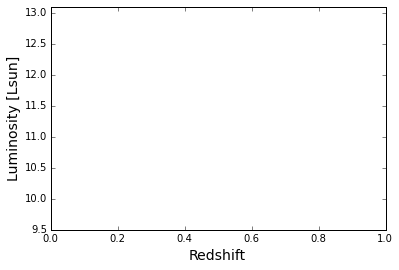

In [12]:
popcolor=['blue','red','green','orange','black']
#import matplotlib.patches as mpatches
#red_patch = mpatches.Patch(color='red', label='The red data')
#plt.legend(handles=[red_patch])
plt.ylim([9.5,13.1])
plt.ylabel('Luminosity [Lsun]',fontsize=14)
plt.xlabel('Redshift',fontsize=14)
#npop=2
for j in range(nm): 
    for k in range(npop):
        ind = np.where(np.log10(all_luminosity_temp[:,j,k,0]) != 12.)
        #plt.plot(z_mid,np.log10(all_luminosity_temp[:,j,k,0]),color=popcolor[k],label=pop_suf[k])
        plt.plot(z_mid[ind[0]],np.log10(all_luminosity_temp[ind[0],j,k,0]),color=popcolor[k])

In [ ]:
popcolor=['blue','red','green','orange','black']
plt.ylim([10,50])
plt.ylabel('Rest Frame Temperature',fontsize=14)
plt.xlabel('Redshift',fontsize=14)
#npop=2
for j in range(nm): 
    for k in range(npop):
        ind = np.where(all_luminosity_temp[:,j,k,1] != 25.)
        #plt.plot(z_mid,(all_luminosity_temp[:,j,k,1]),color=popcolor[k])
        plt.plot(z_mid[ind[0]],(all_luminosity_temp[ind[0],j,k,1]),color=popcolor[k])
        #print ind[0]
        #print z_mid[ind[0]]
        #print all_luminosity_temp[ind[0],j,k,1]    

In [ ]:
print "%d" % (ngal[0])

In [ ]:
area = 1.8 #deg2
from comoving_number_density import *

popcolor=['blue','red','green','orange','black']
plt.ylim([-2,-8])
plt.xlim([9,14])
plt.ylabel('Rest Frame Temperature',fontsize=14)
plt.xlabel('Redshift',fontsize=14)
for i in range(nz):
    #vol=comoving_volume_given_area(area,z_lo[i],z_hi[i], mpc=1)
    vol0=comoving_volume(z_lo[i],z_hi[i],mpc=1)
    vol=((area)/(180./pi)**2.)/(4.*pi)*vol0
    for k in range(npop):
        for j in range(nm): 
            #ngal = np.zeros([nz,nm,npop])
            #model_lum_tot[ipi,i]=alog10(LFIR[indlum]*1e10*mean(ngals[*,ipi,i]/all_completeness[ipi,i]/vol))
            tsts = np.log10(all_luminosity_temp[i,j,k,0]*1e10*ngal[i,j,k]/vol)
            #ind = np.where(np.log10(all_luminosity_temp[i,j,k,0]) != 12.)
            #plt.plot(np.log10(all_luminosity_temp[i,j,k,0])
            print tsts
            #print comoving_volume_given_area(area,z_lo[i],z_hi[i], mpc=1)